# Classificação de Notícias com BERT (Onça, Caseiro e Notícia)

**Trabalho (T2) para disciplina de Inteligência Artificial, feito por Felipe Miranda.**

*Escolhi o treinamento para classificação de sentimento do comentário quanto à onça, ao caseiro e a notícia.*


---



# Importando e tratando dados

Vamos ler o dataset usando pandas.

In [3]:
!pip install transformers --quiet
import pandas as pd

try:
  df = pd.read_csv('oncas_comentarios.csv', sep=',')
  display(df.head())
except Exception as e:
  print(f"Erro: {e}")

,video,onca,caseiro,fake news,ironia,notícia,Conservacionistas,comment_text
0,video0,neutro,neutro,não,sim,neutra,NaN,Solta no congresso
1,video0,neutro,neutro,não,não,boa,NaN,"vídeo direto, respeitoso, sem sensacionalismo ..."
2,video0,neutro,neutro,não,não,boa,NaN,Essa reportagem foi a melhor parabéns
3,video0,neutro,negativo,não,não,neutra,NaN,As patas 🐾 das onças no chão foi um aviso pra ...
4,video0,neutro,negativo,não,não,neutra,NaN,Se o cara viu que onça estava rondando a casa ...





Vamos remover as colunas video, fake news e ironia. Agora é hora de eliminar as duplicatas e remover a coluna.

In [4]:
columns_to_drop = ['video', 'fake news', 'ironia', 'Conservacionistas']
df = df.drop(columns=columns_to_drop)

df.drop_duplicates(inplace=True)

display(df.head())

,onca,caseiro,notícia,comment_text
0,neutro,neutro,neutra,Solta no congresso
1,neutro,neutro,boa,"vídeo direto, respeitoso, sem sensacionalismo ..."
2,neutro,neutro,boa,Essa reportagem foi a melhor parabéns
3,neutro,negativo,neutra,As patas 🐾 das onças no chão foi um aviso pra ...
4,neutro,negativo,neutra,Se o cara viu que onça estava rondando a casa ...


Vamos ver se existe algum dado vazio pra alguma coluna antes de começar a separar os conjuntos.

In [5]:
columns_to_check = ['comment_text', 'caseiro', 'onca', 'notícia']

null_counts = df[columns_to_check].isnull().sum()

empty_comment_text_count = (df['comment_text'] == '').sum()

print("Valores nulos/vazios por coluna:")
print(null_counts)
print(f"'comment_text' {empty_comment_text_count}")

total_empty_or_null = null_counts.sum() + empty_comment_text_count

print(f"\nTotal: {total_empty_or_null}")


Valores nulos/vazios por coluna:
comment_text    0
caseiro         0
onca            0
notícia         0
dtype: int64
'comment_text' 0

Total: 0


Nenhum vazio. Vamos converter os rótulos agora

In [6]:
label_mapping = {
    'neutro': 1,
    'neutra': 1,
    'negativo': 0,
    'ruim': 0,
    'positivo': 2,
    'boa': 2
}

df['onca'] = df['onca'].map(label_mapping)
df['caseiro'] = df['caseiro'].map(label_mapping)
df['notícia'] = df['notícia'].map(label_mapping)

display(df.head())

,onca,caseiro,notícia,comment_text
0,1,1,1,Solta no congresso
1,1,1,2,"vídeo direto, respeitoso, sem sensacionalismo ..."
2,1,1,2,Essa reportagem foi a melhor parabéns
3,1,0,1,As patas 🐾 das onças no chão foi um aviso pra ...
4,1,0,1,Se o cara viu que onça estava rondando a casa ...


Só vamos conferir agora se algum dado tá com a classificação sem ser 0, 1 ou 2. (Ou seja, se deixei passar alguma coisa)

In [7]:
label_columns = ['onca', 'caseiro', 'notícia']
expected_values = {0, 1, 2}

for col in label_columns:
    unexpected_values = df[~df[col].isin(expected_values)][col].unique()
    if len(unexpected_values) > 0:
        print(f"Coluna '{col}' contém valores inesperados: {unexpected_values}")
    else:
        print(f"Coluna '{col}' contém apenas os valores esperados (0, 1, 2).")


Coluna 'onca' contém apenas os valores esperados (0, 1, 2).
Coluna 'caseiro' contém apenas os valores esperados (0, 1, 2).
Coluna 'notícia' contém apenas os valores esperados (0, 1, 2).


Com isso feito agora, vamos pra separação de conjuntos.


---

# Separando os conjuntos de treinamento, validação e teste

Agora vamos usar a lib train_test_split do sklearn pra separar os conjuntos de dados

In [8]:
from sklearn.model_selection import train_test_split

# Separando as features (comment_text) e os labels (onca, caseiro, noticia)
X = df['comment_text']
y = df[['onca', 'caseiro', 'notícia']]

# Dividir 70% para treino e 30% para validação + teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Dividir os 30% restantes (X_temp, y_temp) em validação (15%) e teste (15%)
# Isso significa que cada um será metade do conjunto temporário (0.5 de 0.3 = 0.15)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de validação: {len(X_val)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 3154 amostras
Tamanho do conjunto de validação: 676 amostras
Tamanho do conjunto de teste: 676 amostras


Certo. Temos então os 3 conjuntos: X_train, X_val e X_test.



# Tokenização

---


Escolhi o modelo bert-base-portuguese-cased para realizar a tokenização.

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

print("Tokenizer carregado com sucesso!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer carregado com sucesso!


Agora vamos tokenizar os conjuntos de treinamento, validação e teste.

In [10]:
import torch

def tokenize_data(texts, tokenizer, max_length=128):
    encoded_inputs = tokenizer(texts.tolist(),
                               padding='max_length',
                               truncation=True,
                               max_length=max_length,
                               return_tensors='pt')
    return encoded_inputs['input_ids'], encoded_inputs['attention_mask']

# Tokenizar os conjuntos
X_train_input_ids, X_train_attention_mask = tokenize_data(X_train, tokenizer)
X_val_input_ids, X_val_attention_mask = tokenize_data(X_val, tokenizer)
X_test_input_ids, X_test_attention_mask = tokenize_data(X_test, tokenizer)

print(f"Tamanho dos input_ids de treino: {X_train_input_ids.shape}")
print(f"Tamanho dos attention_mask de treino: {X_train_attention_mask.shape}")

print(f"Tamanho dos input_ids de validação: {X_val_input_ids.shape}")
print(f"Tamanho dos attention_mask de validação: {X_val_attention_mask.shape}")

print(f"Tamanho dos input_ids de teste: {X_test_input_ids.shape}")
print(f"Tamanho dos attention_mask de teste: {X_test_attention_mask.shape}")

Tamanho dos input_ids de treino: torch.Size([3154, 128])
Tamanho dos attention_mask de treino: torch.Size([3154, 128])
Tamanho dos input_ids de validação: torch.Size([676, 128])
Tamanho dos attention_mask de validação: torch.Size([676, 128])
Tamanho dos input_ids de teste: torch.Size([676, 128])
Tamanho dos attention_mask de teste: torch.Size([676, 128])


### Configurando o modelo para classificação

Agora vamos configurar o modelo BERT para a tarefa de classificação, especificando o número de classes que temos (3 para onça, caseiro e notícia).

Lembrando que colocamos 9 pois é 3*3 e vamos usar one-hot encoding

In [44]:
from transformers import AutoModelForSequenceClassification

# Definir o número total de classes para o problema multi-label multi-class
# 3 rótulos (onca, caseiro, notícia) * 3 classes por rótulo (0, 1, 2) = 9
num_labels_total = 9

# Carregar o modelo BERT para classificação de sequência
# AutoModelForSequenceClassification já adiciona uma camada de classificação no topo do BERT
# que utiliza o token [CLS] para fazer a predição.
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=num_labels_total)

print("Modelo BERT para classificação carregado com sucesso!")
print(f"Número total de logits de saída configurado para o modelo: {num_labels_total}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo BERT para classificação carregado com sucesso!
Número total de logits de saída configurado para o modelo: 9


# Treinamento do Modelo BERT

Agora vamos configurar o treinamento do modelo BERT usando a lib transformers.

Vamos usar one-hot encoding pro conjunto de treino e de validação por enquanto.


In [45]:
from torch.utils.data import Dataset
import torch

class CustomTextDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

def one_hot_encode_multi_label_multiclass(labels_tensor, num_classes_per_label=3):
    batch_size = labels_tensor.shape[0]
    num_label_tasks = labels_tensor.shape[1] # Should be 3 (onca, caseiro, noticia)

    # Initialize a tensor of zeros of shape (batch_size, num_label_tasks * num_classes_per_label)
    one_hot_labels = torch.zeros(batch_size, num_label_tasks * num_classes_per_label, dtype=torch.float)

    for i in range(num_label_tasks):
        class_ids = labels_tensor[:, i].long() # Get class IDs for current label task
        start_idx = i * num_classes_per_label # Starting position for one-hot block

        # Create indices for scatter_ to place the 1s
        # For each batch element `j`, the index will be `start_idx + class_ids[j]`
        indices = (start_idx + class_ids).unsqueeze(1)

        one_hot_labels.scatter_(1, indices, 1.0)

    return one_hot_labels

# Criar datasets para treino, validação e teste
# Converter y_train e y_val para tensores antes de one-hot encoding
y_train_tensor = torch.tensor(y_train.values)
y_val_tensor = torch.tensor(y_val.values)

y_train_encoded = one_hot_encode_multi_label_multiclass(y_train_tensor.float())
y_val_encoded = one_hot_encode_multi_label_multiclass(y_val_tensor.float())

train_dataset = CustomTextDataset(X_train_input_ids, X_train_attention_mask, y_train_encoded)
val_dataset = CustomTextDataset(X_val_input_ids, X_val_attention_mask, y_val_encoded)
# test_dataset = CustomTextDataset(X_test_input_ids, X_test_attention_mask, torch.tensor(y_test.values).float()) # Not used in training

print("Datasets criados")

Datasets criados


aqui, vamos deixar como 3*3

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    # p.predictions virá do modelo com shape (batch_size, 9)
    # Precisamos reshapar para (3 para 3)
    predictions_reshaped = p.predictions.reshape(p.predictions.shape[0], 3, 3)

    # argmax ao longo do eixo das classes (axis=2)
    predictions = np.argmax(predictions_reshaped, axis=2) # predictions agora tem shape (batch_size, 3)

    # p.label_ids é o tensor labels original que foi one-hot encoded (batch_size, 9)
    # Precisamos decodificá-lo de volta para (batch_size, 3) de IDs de classe
    labels_encoded_reshaped = p.label_ids.reshape(p.label_ids.shape[0], 3, 3)
    labels = np.argmax(labels_encoded_reshaped, axis=2) # labels agora tem shape (batch_size, 3)

    accuracies = []
    f1_scores = []

    # iterando sobre cada rótulo (onca, caseiro, noticia) - agora há 3 rótulos
    for i in range(labels.shape[1]): # Este loop agora irá de 0 a 2
        # Calcula acurácia para o rótulo atual
        acc = accuracy_score(labels[:, i], predictions[:, i])
        accuracies.append(acc)

        # Calcula F1-score para o rótulo atual
        f1 = f1_score(labels[:, i], predictions[:, i], average='weighted', zero_division=0)
        f1_scores.append(f1)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)

    return {
        'accuracy': avg_accuracy,
        'f1_score': avg_f1,
        'accuracy_onca': accuracies[0] if len(accuracies) > 0 else 0,
        'accuracy_caseiro': accuracies[1] if len(accuracies) > 1 else 0,
        'accuracy_noticia': accuracies[2] if len(accuracies) > 2 else 0
    }

Conforme pedido, Usar AdamW com lr=2e-5 e epochs=10;



Mostrar o loss e a acurácia de treino e de validação por época.

In [26]:
from transformers import TrainingArguments, Trainer
import os

!pip install --upgrade transformers --quiet

# Definir os argumentos de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch', # Changed from evaluation_strategy to eval_strategy
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_score',
    greater_is_better=True,
    report_to=['none']
)

# Inicializar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Treinar o modelo
trainer.train()

print("Treinamento concluído!")

/tmp/ipython-input-2698571694.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Accuracy Onca,Accuracy Caseiro,Accuracy Noticia
1,0.047400,0.259543,0.880178,0.874105,0.834320,0.875740,0.930473
2,0.034400,0.285166,0.875247,0.870466,0.832840,0.875740,0.917160
3,0.029500,0.307834,0.879684,0.870775,0.822485,0.884615,0.931953
4,0.028800,0.316841,0.875740,0.872765,0.829882,0.865385,0.931953
5,0.024600,0.330203,0.878698,0.873914,0.828402,0.875740,0.931953
6,0.015900,0.343397,0.880178,0.870082,0.837278,0.872781,0.930473
7,0.011100,0.354605,0.875247,0.872410,0.818047,0.874260,0.933432
8,0.007300,0.362869,0.869329,0.869283,0.810651,0.866864,0.930473
9,0.013100,0.364938,0.873767,0.869084,0.819527,0.869822,0.931953
10,0.009100,0.366143,0.869822,0.865895,0.815089,0.865385,0.928994


Treinamento concluído!


### Gráfico de Evolução do Loss e Acurácia

Vamos plotar a evolução do loss de treino e validação, e da acurácia de validação ao longo das épocas.

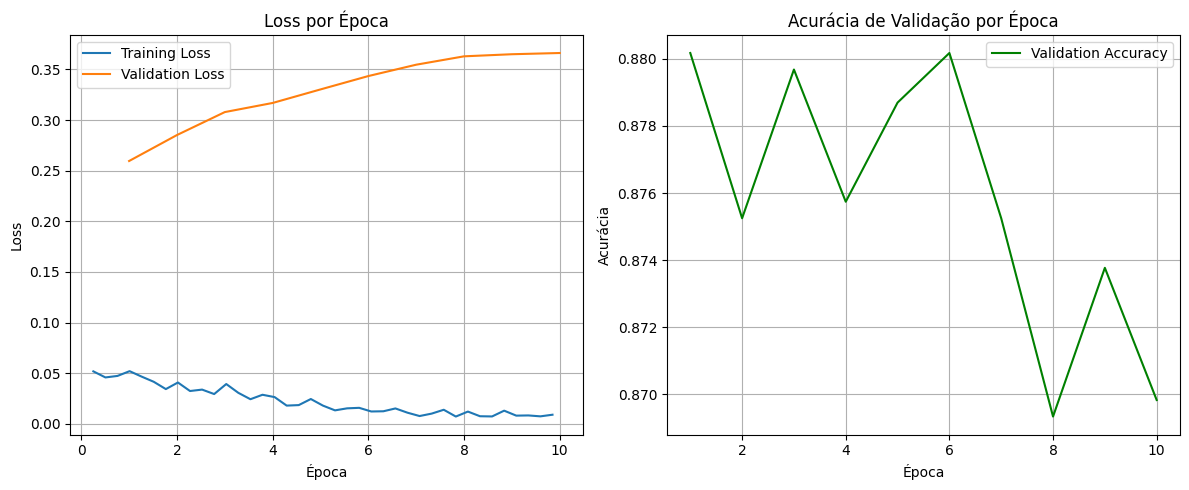

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregar os logs de treinamento
log_history = pd.DataFrame(trainer.state.log_history)

# Filtrar logs de treino e avaliação
train_logs = log_history[log_history['loss'].notna()]
eval_logs = log_history[log_history['eval_loss'].notna()]

# Plotar o Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotar a Acurácia de Validação
plt.subplot(1, 2, 2)
plt.plot(eval_logs['epoch'], eval_logs['eval_accuracy'], label='Validation Accuracy', color='green')
plt.title('Acurácia de Validação por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Avaliação
Vamos fazer o one-hot encoding também no conjunto de testes. Vamos usar o `trainer.predict()` para obter as classificações que o modelo treinado realizou. Em seguida, vamos comparar as que tiveram erro

Primeiro de tudo, vamos converter pra um tensor com torch e depois one-hot-encoding


In [36]:
import torch

y_test_tensor = torch.tensor(y_test.values)

# One-hot encode
y_test_encoded = one_hot_encode_multi_label_multiclass(y_test_tensor.float())

test_dataset = CustomTextDataset(X_test_input_ids, X_test_attention_mask, y_test_encoded)

print("Dataset pronto")

Dataset pronto


Vamos agora puxar as labels que resultaram nas predictions

True, as labels de fato;
Predicted, as que o modelo mediu



In [37]:
predictions_output = trainer.predict(test_dataset)
raw_predictions = predictions_output.predictions
true_labels_encoded = predictions_output.label_ids

print("OK")

OK


Como fizemos O-HE, vamos ter que remodelar as predições para o modelo de 0, 1 e 2 de novo ao invés de onca_0, onca1, onca2 (por exemplo)



In [39]:
import numpy as np

# Reshape raw_predictions
predictions_reshaped = raw_predictions.reshape(raw_predictions.shape[0], 3, 3)
predicted_class_ids = np.argmax(predictions_reshaped, axis=2)

# Reshape true_labels_encoded
true_labels_encoded_reshaped = true_labels_encoded.reshape(true_labels_encoded.shape[0], 3, 3)
true_class_ids = np.argmax(true_labels_encoded_reshaped, axis=2)

print("Remodelados")

Remodelados


Usando o metrics em cada label, vamos obter o precision, recall, and F1-score pra cada classe e também vamos filtrar exemplos de erros de classificação.



In [43]:
from sklearn.metrics import classification_report

#labels
label_names = ['negativo', 'neutro', 'positivo']

# Label tasks
task_labels = ['onca', 'caseiro', 'noticia']

print("\n--- Classificação ---")
for i, task_name in enumerate(task_labels):
    print(f"\nClassificação para '{task_name.capitalize()}':")
    print(classification_report(true_class_ids[:, i], predicted_class_ids[:, i], target_names=label_names, zero_division=0))


print("\n--- Exemplos de erros de classificação ---")

# Create a DataFrame for easier handling of comments and labels
results_df = pd.DataFrame({
    'comment_text': X_test.reset_index(drop=True),
    'true_onca': true_class_ids[:, 0],
    'predicted_onca': predicted_class_ids[:, 0],
    'true_caseiro': true_class_ids[:, 1],
    'predicted_caseiro': predicted_class_ids[:, 1],
    'true_noticia': true_class_ids[:, 2],
    'predicted_noticia': predicted_class_ids[:, 2]
})

# mapeamento de sentimento
inverse_label_mapping = {0: 'negativo', 1: 'neutro', 2: 'positivo'}

num_examples_to_show = 5

for i, task_name in enumerate(task_labels):
    # filtrar apenas os classificados errados (misclassified)
    misclassified_mask = (results_df[f'true_{task_name}'] != results_df[f'predicted_{task_name}'])
    misclassified_comments = results_df[misclassified_mask].copy()

    if not misclassified_comments.empty:
        print(f"\nExemplos de classificação incorreta para '{task_name.capitalize()}':")
        misclassified_comments['real'] = misclassified_comments[f'true_{task_name}'].map(inverse_label_mapping)
        misclassified_comments['predito'] = misclassified_comments[f'predicted_{task_name}'].map(inverse_label_mapping)

        display(misclassified_comments[[
            'comment_text', 'real', 'predito'
        ]].head(num_examples_to_show))
    else:
        print(f"No misclassified examples found for '{task_name.capitalize()}'.")


--- Classificação ---

Classificação para 'Onca':
              precision    recall  f1-score   support

    negativo       0.61      0.59      0.60       107
      neutro       0.89      0.91      0.90       516
    positivo       0.52      0.47      0.50        53

    accuracy                           0.82       676
   macro avg       0.67      0.66      0.66       676
weighted avg       0.82      0.82      0.82       676


Classificação para 'Caseiro':
              precision    recall  f1-score   support

    negativo       0.63      0.39      0.48        62
      neutro       0.92      0.93      0.93       564
    positivo       0.54      0.70      0.61        50

    accuracy                           0.87       676
   macro avg       0.70      0.67      0.67       676
weighted avg       0.86      0.87      0.86       676


Classificação para 'Noticia':
              precision    recall  f1-score   support

    negativo       0.72      0.49      0.58        47
      neutro    

,comment_text,real,predito
1,Maranhão o sul muita mata derrubado pra pl...,neutro,negativo
5,Coitada tava com fome😢e o pobre do senhorzinho...,positivo,neutro
18,Para mim estaria de parabéns se tivesse soltad...,negativo,positivo
26,"Com o final da guerra do Viatnã , os tigres en...",neutro,negativo
35,Ou seja mstou o homem pra Comer,negativo,neutro



Exemplos de classificação incorreta para 'Caseiro':


,comment_text,real,predito
2,Moro no município de Miranda tem que se cuidar...,negativo,neutro
3,"Triste demais, cara teve aviso e mesmo assim ...",negativo,neutro
5,Coitada tava com fome😢e o pobre do senhorzinho...,positivo,neutro
7,Os caras jamais imaginava que a brincadeira ia...,neutro,negativo
13,Acho q ela está magra por passar fome.... deve...,neutro,positivo



Exemplos de classificação incorreta para 'Noticia':


,comment_text,real,predito
4,Onça com rabo de leopardo. Quem fez a animaçã...,negativo,neutro
19,Nossa como IA aumenta.... o cara vivia sozinho...,negativo,neutro
47,É tão bom ouvir uma conversa de qualidade,positivo,neutro
49,Conversa fiada. Tem vídeo desse senhor brincan...,negativo,neutro
71,"Falaram falaram e não disseram nada 😅, sou mai...",negativo,neutro


# Classificação de Comentários do Usuário

Agora vamos criar um script interativo para que você possa inserir um comentário e ver a classificação do modelo para 'onça', 'caseiro' e 'notícia'.

In [ ]:
import torch
import numpy as np

# Mapeamento inverso para exibir os resultados
inverse_label_mapping = {0: 'negativo', 1: 'neutro', 2: 'positivo'}

def classify_user_comment(comment_text, model, tokenizer):
    # 1. Tokenizar o input do usuário
    encoded_input = tokenizer(comment_text,
                              padding='max_length',
                              truncation=True,
                              max_length=128,
                              return_tensors='pt')

    # 2. Mover o input para o mesmo dispositivo do modelo (CPU/GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # 3. Fazer a predição
    model.eval() # Colocar o modelo em modo de avaliação
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits.detach().cpu().numpy() # Mover logits para CPU e converter para numpy

    # 4. Processar os logits para obter as classes preditas
    # Reshape de (1, 9) para (1, 3, 3) e aplicar argmax
    predictions_reshaped = logits.reshape(1, 3, 3)
    predicted_class_ids = np.argmax(predictions_reshaped, axis=2)

    # 5. Mapear para rótulos legíveis
    results = {}
    task_labels = ['onca', 'caseiro', 'notícia'] # Usar os nomes originais das tarefas
    for i, task_name in enumerate(task_labels):
        predicted_sentiment_id = predicted_class_ids[0, i]
        results[task_name] = inverse_label_mapping[predicted_sentiment_id]

    return results

# Loop
while True:
    user_input = input("Digite um comentário para classificar (ou 'sair' para encerrar): ")
    if user_input.lower() == 'sair':
        break

    if user_input.strip() == '':
        print("comentário vazio!")
        continue

    classification_results = classify_user_comment(user_input, model, tokenizer)
    print("\n--- Resultado ---")
    for task, sentiment in classification_results.items():
        print(f"{task.capitalize()}: {sentiment}")
    print("-----------------------------------\n")

print("Classificação encerrada.")


Digite um comentário para classificar (ou 'sair' para encerrar): Infelizmente esta onça, tem que ser abatida, pois a partir deste ataque fatal, ela , assimilou que seres humanos, fazem parte de seu cardápio, muito triste, que Deus conforte seus familiares.

--- Resultado ---
Onca: neutro
Caseiro: neutro
Notícia: positivo
-----------------------------------

Digite um comentário para classificar (ou 'sair' para encerrar): Esse cara já deve ter provoca o animal

--- Resultado ---
Onca: neutro
Caseiro: neutro
Notícia: positivo
-----------------------------------

Digite um comentário para classificar (ou 'sair' para encerrar): Peninha de onça dá nisso

--- Resultado ---
Onca: positivo
Caseiro: neutro
Notícia: positivo
-----------------------------------

Digite um comentário para classificar (ou 'sair' para encerrar): Muito triste.  Deus o tenha.

--- Resultado ---
Onca: positivo
Caseiro: neutro
Notícia: positivo
-----------------------------------

